Lithology log
====

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import os
from string import ascii_lowercase
from sbp_modelling.multi_source import model
from cycler import cycler
from matplotlib.cm import get_cmap

plt.style.use('./mpl/manuscript.mplstyle')

mscl_path = '../../data/mscl'

In [2]:
mscl_names = ('GH-H-PGC7', 'GH-H-PGC8', 'GH-H-JPC4A', 'GH-H-JPC5A')
amp_threshold = 60

mscl = []
for name in mscl_names:
    mscl.append(pd.read_csv(os.path.join(mscl_path, name + '.csv'), index_col=0))
    
elastic_params = {
    'Water': (1480, 1.),
    'Lithology 1': (1515, 1.9),
    'Lithology 2': (1650, 2.1),
}

In [3]:
def label_axis(axis, i, offset=(-30, 0), second=False):
    trans = transforms.blended_transform_factory(axis.transAxes, axis.transAxes)
    axis.annotate(f'{ascii_lowercase[i]})', xy=(0, 1), xytext=offset,
                  xycoords=trans, textcoords='offset points',
                  va='center', ha='left')
    return i + 1

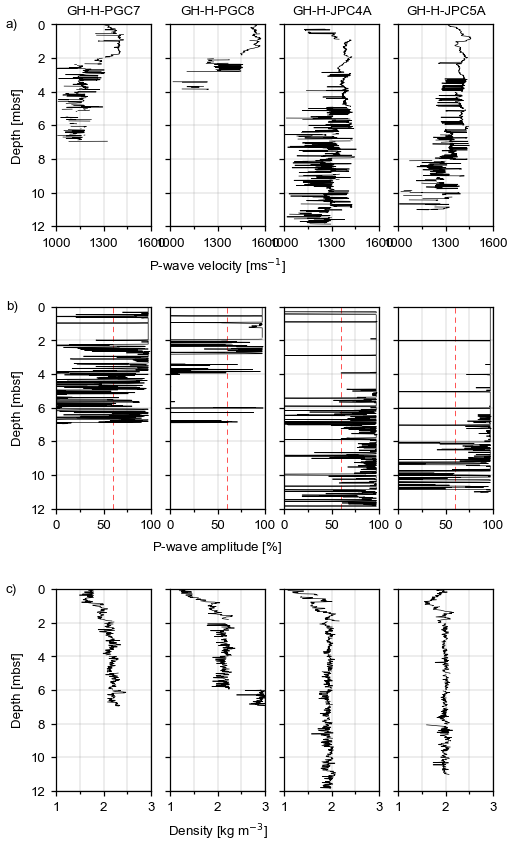

In [4]:
figsize = list(plt.rcParams['figure.figsize'])
figsize[1] = figsize[0] * 1.8
fig = plt.figure(constrained_layout=False, figsize=figsize)
#gs = fig.add_gridspec(3, 2, wspace=0.2, width_ratios=[4, 4])
fig_a = fig.add_gridspec(3, 4, wspace=0.2, hspace=0.4)

ax = np.empty((3, 4), dtype=object)
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sharey = None
        ax[i, j] = fig.add_subplot(fig_a[i, j])
        ax[i, j].grid(which='both')
        ax[0, j].set(title=mscl_names[j])
        if j == 0:
            ax[i, j].set(ylabel='Depth [mbsf]')
        else:
            ax[i, 0].get_shared_y_axes().join(ax[i, 0], ax[i, j])
            ax[i, j].set_yticklabels([])
        ax[i, j].set(ylim=(0, 12))
            
        if i == 0:
            ticks = np.linspace(1000, 1600, 5)
        if i == 1:
            ticks = np.linspace(0, 100, 5)
        if i == 2:
            ticks = np.linspace(1, 3, 5)
            
        ax[i, j].set(xlim=(ticks[0], ticks[-1]))
        ax[i, j].set_xticks(ticks, minor=True)
        ax[i, j].set_xticks(ticks[::2], minor=False)
        
        ax[i, j].invert_yaxis()
            
ax[0, 1].set(xlabel='P-wave velocity [ms$^{-1}$]')
ax[1, 1].set(xlabel='P-wave amplitude [%]$~$')
ax[2, 1].set(xlabel='Density [kg m$^{-3}$]')
    
## MSCL

features = []
kwargs = dict(color='black', linewidth=0.4)
for i, core in enumerate(mscl):
    ax[0, i].plot(core['pw_vel'].values, core.index, **kwargs)
    ax[1, i].axvline(amp_threshold, color='red', linestyle='--', dashes=(8, 6), linewidth=0.4)
    ax[1, i].plot(core['pw_amp'].values, core.index, **kwargs)
    ax[2, i].plot(core['density'].values[::2], core.index[::2], label=mscl_names[i], **kwargs)
    
    ind = (core['pw_amp'] > amp_threshold) & ~core['density'].isna() & ~core['pw_vel'].isna()
    #ax[2].plot(core['pw_vel'].loc[ind], core['density'].loc[ind], '.', alpha=0.1, color=palette(i))
    
    features.append(np.concatenate((core['pw_vel'].loc[ind].values[:, np.newaxis], core['density'].loc[ind].values[:, np.newaxis]), axis=1))

for i in range(ax.shape[0]):
    label_axis(ax[i, 0], i)

fig.savefig('../../manuscript/figures/si_fig01_pg_1.pdf')

#counter = label_axis(hist_top, counter)


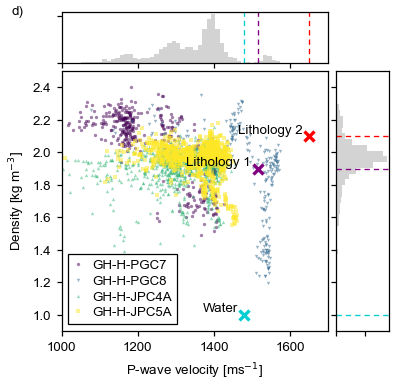

In [12]:
figsize2 = list(plt.rcParams['figure.figsize'])
figsize2[0] *= 0.75
figsize2[1] = figsize2[0]
fig2 = plt.figure(constrained_layout=False, figsize=figsize2)
#gs = fig.add_gridspec(3, 2, wspace=0.2, width_ratios=[4, 4])
fig_b = fig2.add_gridspec(2, 2, height_ratios=[0.2, 1], width_ratios=[1, 0.2], wspace=0.05, hspace=0.05)

xplot = fig2.add_subplot(fig_b[1, 0])
hist_top = fig2.add_subplot(fig_b[0, 0], sharex=xplot)
hist_right = fig2.add_subplot(fig_b[1, -1], sharey=xplot)

plt.setp(hist_top.get_yticklabels(), visible=False)
plt.setp(hist_right.get_yticklabels(), visible=False)
plt.setp(hist_top.get_xticklabels(), visible=False)
plt.setp(hist_right.get_xticklabels(), visible=False)

xplot.set(xlabel='P-wave velocity [ms$^{-1}$]', ylabel='Density [kg m$^{-3}$]', xlim=(1000, 1700), ylim=(0.9, 2.5))

cmap = get_cmap('viridis')
custom_cycler = (cycler('color', cmap(np.linspace(0, 1, 4))) +
    cycler('marker', ['o', 'v', '^', 's']))
xplot.set_prop_cycle(custom_cycler)

for i, core in enumerate(mscl):
    xplot.plot(features[i][:, 0], features[i][:, 1], markersize=2, linestyle='none', markeredgewidth=0, alpha=0.5, label=core)
    
leg = xplot.legend(mscl_names, ncol=1, loc='lower left', frameon=True)

features2 = np.concatenate(features)
    
kwargs = dict(color='lightgray', bins=50)
hist_top.hist(features2[:, 0], **kwargs)
hist_right.hist(features2[:, 1], orientation='horizontal', **kwargs)
    
for label, (v_p, rho) in elastic_params.items():
    if label == 'Water':
        color = 'darkturquoise'
    elif label == 'Lithology 1':
        color = 'purple'
    else:
        color = 'red'
    xplot.plot(v_p, rho, 'x', alpha=1, color=color, markersize=6, mew=2)
    hist_top.axvline(v_p, color=color, linestyle='--', dashes=(4, 3), linewidth=0.8)
    hist_right.axhline(rho, color=color, linestyle='--', dashes=(4, 3), linewidth=0.8)
    xplot.annotate(label, xy=(v_p, rho), xytext=(-4, 0), ha='right', va='bottom', textcoords='offset points')
    
label_axis(hist_top, ax.shape[1] - 1)

fig2.savefig('../../manuscript/figures/si_fig01_pg_2.pdf')